In [1]:
import pandas as pd

#Plot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import calendar
import calplot 

# Score model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Model
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


In [2]:
url = "https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/main/ProjectAssignmentData/Dataset-PT.csv"
df = pd.read_csv(url,header=1)
df['Date'] = pd.to_datetime(df['Calendar_date'], format='%Y%m%d')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545103 entries, 0 to 545102
Data columns (total 32 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   Calendar_date                      545103 non-null  int64         
 1   route_id                           545103 non-null  int64         
 2   bus_id                             545103 non-null  int64         
 3   stop_sequence                      545103 non-null  int64         
 4   arrival_delay                      545103 non-null  int64         
 5   dwell_time                         545103 non-null  int64         
 6   travel_time_for_previous_section   545103 non-null  int64         
 7   scheduled_travel_time              545103 non-null  int64         
 8   upstream_stop_delay                545103 non-null  int64         
 9   origin_delay                       545103 non-null  int64         
 10  previous_bus_delay  

In [4]:
max_delay_row = df[df['arrival_delay'] == df['arrival_delay'].max()]
print(max_delay_row)

        Calendar_date  route_id  bus_id  stop_sequence  arrival_delay  \
490068       20220609         4   44063             19           2257   

        dwell_time  travel_time_for_previous_section  scheduled_travel_time  \
490068          26                                41                     57   

        upstream_stop_delay  origin_delay  ...  factor(weather)Snow  \
490068                 2231          1285  ...                    0   

        factor(temperature)Cold  factor(temperature)Extra_cold  \
490068                        0                              0   

        factor(temperature)Normal factor(day_of_week)weekday  \
490068                          1                          1   

       factor(day_of_week)weekend factor(time_of_day)Afternoon_peak  \
490068                          0                                 0   

       factor(time_of_day)Morning_peak  factor(time_of_day)Off-peak       Date  
490068                               0                           

In [5]:
# The average waiting time based on the given frequency should be Headway/2 ( 6/2 = 3 minutes)
# The Waiting Time Paradox: if a bus arrives on average every 6 minutes, the average waiting time will be 6 minutes.

# Simulating Wait Times

import numpy as np
N = df['bus_id'].nunique()  # number of buses
tau = 6 # using the maximum of 4-6 minutes/departure

rand = np.random.RandomState(42)  # universal random seed
bus_arrival_times = N * tau * np.sort(rand.rand(N))

intervals = np.diff(bus_arrival_times)
intervals.mean()

5.927183545449976

In [6]:
df = df.drop(['weather','Calendar_date','route_id', 'bus_id'], axis = 1)
columns_to_drop = [
    'temperature',
    'factor(weather)Light_Rain', 'factor(weather)Light_Snow',
    'factor(weather)Normal', 'factor(weather)Rain', 'factor(weather)Snow',
    'factor(temperature)Cold', 'factor(temperature)Extra_cold',
    'factor(temperature)Normal', 'factor(day_of_week)weekday',
    'factor(day_of_week)weekend', 'factor(time_of_day)Afternoon_peak',
    'factor(time_of_day)Morning_peak', 'factor(time_of_day)Off-peak'
]
for column in columns_to_drop:
    df.pop(column)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545103 entries, 0 to 545102
Data columns (total 14 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   stop_sequence                     545103 non-null  int64         
 1   arrival_delay                     545103 non-null  int64         
 2   dwell_time                        545103 non-null  int64         
 3   travel_time_for_previous_section  545103 non-null  int64         
 4   scheduled_travel_time             545103 non-null  int64         
 5   upstream_stop_delay               545103 non-null  int64         
 6   origin_delay                      545103 non-null  int64         
 7   previous_bus_delay                545103 non-null  int64         
 8   previous_trip_travel_time         545103 non-null  int64         
 9   traffic_condition                 545103 non-null  float64       
 10  recurrent_delay                 

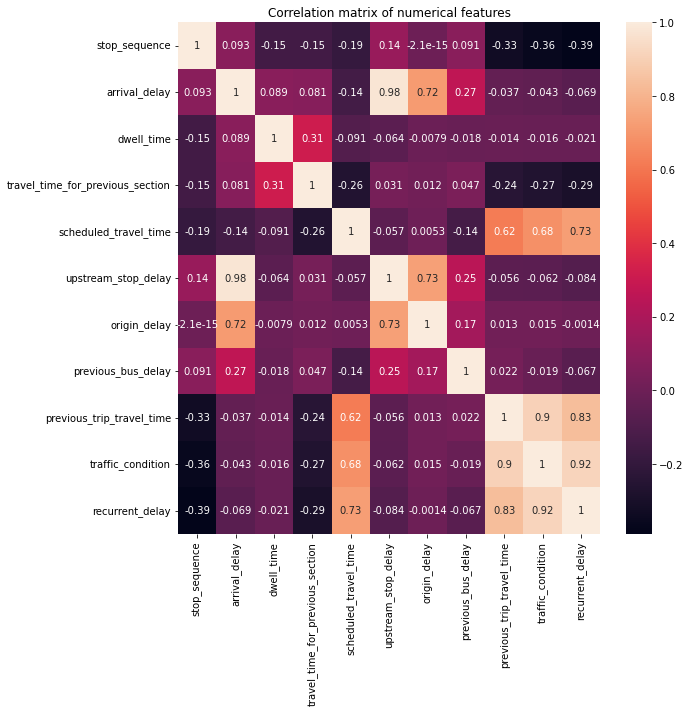

In [8]:
corr_matrix = df.corr()
corr_matrix['arrival_delay'].sort_values(ascending=False)
plt.subplots(figsize=(10,10))
corr = df.corr()
sns.heatmap(corr, annot = True)
plt.title("Correlation matrix of numerical features")
plt.tight_layout()
plt.show()

In [9]:
# Extract only 'Weekdays' from day_of_week to train
# Filter the data
df_weekday = df[df['day_of_week'] == 'weekday']
df_weekend = df[df['day_of_week'] == 'weekend']

print(df_weekday.shape)
print(df_weekend.shape)

(418149, 14)
(126954, 14)


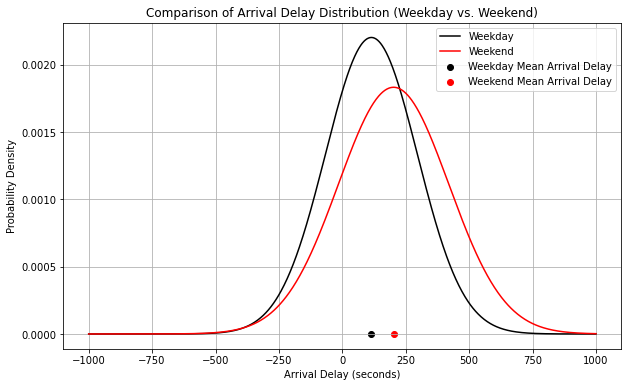

In [10]:
from scipy.stats import norm

# Check the distributions of weekday and weekend delays

# Extract 'arrival_delay' data for both datasets
arrival_delay_weekday = df_weekday['arrival_delay']
arrival_delay_weekend = df_weekend['arrival_delay']

# Calculate mean and standard deviation for each dataset
mean_weekday = arrival_delay_weekday.mean()
std_dev_weekday = arrival_delay_weekday.std()
mean_weekend = arrival_delay_weekend.mean()
std_dev_weekend = arrival_delay_weekend.std()

# Generate x values for the probability density functions (PDFs)
x = np.linspace(-1000, 1000, 1000)

# Calculate PDFs for the normal distributions
pdf_weekday = norm.pdf(x, loc=mean_weekday, scale=std_dev_weekday)
pdf_weekend = norm.pdf(x, loc=mean_weekend, scale=std_dev_weekend)

# Create a plot
plt.figure(figsize=(10, 6))

# Plot the PDFs for both datasets
plt.plot(x, pdf_weekday, label='Weekday', color='black')
plt.plot(x, pdf_weekend, label='Weekend', color='red')

# Add dots for the mean arrival delays
plt.scatter([mean_weekday], [0], color=['black'], marker='o', label='Weekday Mean Arrival Delay')
plt.scatter([mean_weekend], [0], color=['red'], marker='o', label='Weekend Mean Arrival Delay')

plt.xlabel('Arrival Delay (seconds)')
plt.ylabel('Probability Density')
plt.title('Comparison of Arrival Delay Distribution (Weekday vs. Weekend)')
plt.legend()
plt.grid(True)

#plt.grid(False)
plt.show()

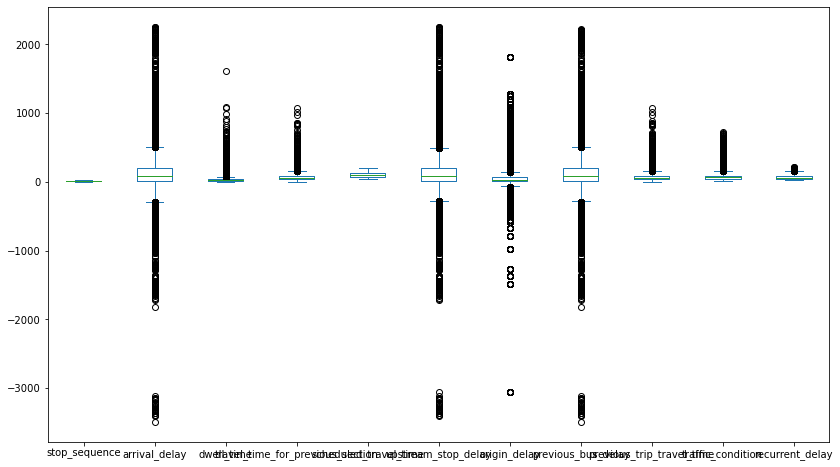

In [11]:
df.plot(kind='box',figsize=(14,8))
plt.show()